# Tutorial 3: Hawai'ian Islands

In this tutorial, we will generate Figure 5 in McNab & Ball, (in submission). This figure includes pressure, temperature and Tp estimates for the Hawai'ian Island of O'ahu.

## Import Code

In [1]:
from meltPT import *
import pyMelt as m
import matplotlib.pyplot as plt

## Generate Data

### Read in and isolate O'ahu data

Read in compilation dataset of Hawaiian samples from McNab & Ball, (2022; Dataset S1). We want take only samples from our Hawaii database that correspond to the island of Oahu. The other islands are shown below for users to try. User can also try adding a second island to perform the calculations on two islands at once.

In [2]:
df = pd.read_csv("../Data/Hawaii.csv", sep=',')

# Island options: Niihau / Kaula / Kauai / Oahu / Molokai / Maui / Kahoolawe / Lanai / Hawaii
Island = "Oahu"
Island2 = np.nan

# Only retain Island and Island2 samples
if Island2 is None:
    df1 = df.loc[(df['Province']==Island)]
else:
    df1 = df.loc[(df['Province']==Island) | (df['Province']==Island2)]

### Treat Shield, Post-Shield and Rejuvenated Phases Differently

Here, assume that different phases of volcanism have different source compositions. Unlike in Tutorials 1 and 2, here different samples require different H2O/Ce and src_FeIII_totFe values. So we add H2O and src_FeIII_totFe columns to the input pandas dataframe.

In [3]:
# Calculate water based on different H2O/Ce values in main text
df1.loc[(df1['Stage']=="Shield"), 'H2O'] = 144. * df1.loc[(df1['Stage']=="Shield"), 'Ce'] / 10000
df1.loc[(df1['Stage']=="Post-Shield"), 'H2O'] = 136. * df1.loc[(df1['Stage']=="Post-Shield"), 'Ce'] / 10000
df1.loc[(df1['Stage']=="Rejuvenated"), 'H2O'] = 211. * df1.loc[(df1['Stage']=="Rejuvenated"), 'Ce'] / 10000

# Assign src_FeIII_totFe values in main text
# Multiplying by zero of the same dataframe shape prevents errors.
df1.loc[(df1['Stage']=="Shield"), 'src_FeIII_totFe'] = 0.15 + 0 * df1.loc[(df1['Stage']=="Shield"), 'Ce']
df1.loc[(df1['Stage']=="Post-Shield"), 'src_FeIII_totFe'] = 0.15 + 0 * df1.loc[(df1['Stage']=="Post-Shield"), 'Ce']
df1.loc[(df1['Stage']=="Rejuvenated"), 'src_FeIII_totFe'] = 0.17 + 0 * df1.loc[(df1['Stage']=="Rejuvenated"), 'Ce']

/home/mcnab/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/mcnab/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value


### Filter for Ce and save to a csv

See Tutorial 2 for comprehensive explanation

In [4]:
df = df1.loc[(df1['Ce']>0)]
df.to_csv("../Data/province.csv", sep=',')

### Read in data, backtrack and calculate pressure and temperature

See Tutorial 1 for comprehensive explanation

In [5]:
s = Suite("../Data/province.csv", min_MgO=8.5)
b = BacktrackOlivineFractionation()
s.backtrack_compositions(backtracker=b)
s.compute_pressure_temperature(min_SiO2=40.)

/home/mcnab/Melting/meltPT/meltPT/parse.py:79: UserWarning: Input csv does not contain a Fe2O3 column: we will try to fill it for you, or set it to zero.
  warnings.warn(message)
/home/mcnab/Melting/meltPT/meltPT/parse.py:79: UserWarning: Input csv does not contain a Cr2O3 column: we will try to fill it for you, or set it to zero.
  warnings.warn(message)
/home/mcnab/Melting/meltPT/meltPT/parse.py:79: UserWarning: Input csv does not contain a NiO column: we will try to fill it for you, or set it to zero.
  warnings.warn(message)
/home/mcnab/Melting/meltPT/meltPT/parse.py:79: UserWarning: Input csv does not contain a CoO column: we will try to fill it for you, or set it to zero.
  warnings.warn(message)
/home/mcnab/Melting/meltPT/meltPT/parse.py:79: UserWarning: Input csv does not contain a CO2 column: we will try to fill it for you, or set it to zero.
  warnings.warn(message)
/home/mcnab/Melting/meltPT/meltPT/parse.py:79: UserWarning: Input csv does not contain a FeO_tot column: we wil

### Calculate Tp

See Tutorial 1 for comprehensive explanation

In [6]:
# Set up mantle lithology
lz = m.lithologies.katz.lherzolite()
mantle = m.mantle([lz], [1], ['Lz'])
max_P = -lz.parameters['A2'] / (2.*lz.parameters['A3'])
P_sol = np.arange(0., max_P, 0.1)
T_sol = [lz.TSolidus(P) for P in P_sol]

# calculate Tp
s.find_suite_potential_temperature(mantle, find_bounds=True)

## Plot Figure 5c,i,o,u

Here, we use our results to generate a similar figure to that seen in Figure 5c,i,o,u of McNab and Ball (in submission).

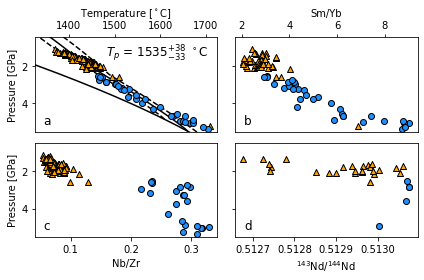

In [7]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, sharey=True)

# ------------------
# ---- Figure 5c (top left)
# ------------------

# Plot solidus
ax1.plot(T_sol, P_sol, "k")

# Plot best fitting melt path
ax1.plot(s.path.T, s.path.P, "-", color="k", zorder=1)

# Plot bounding melt paths
ax1.plot(s.upper_path.T, s.upper_path.P, "--", color="k", zorder=1)
ax1.plot(s.lower_path.T, s.lower_path.P, "--", color="k", zorder=1)

# Plot data
ax1.scatter(s.PT['T'][s.data['Stage']=="Shield"], s.PT['P'][s.data['Stage']=="Shield"],
            marker="^", facecolors="orange", edgecolor="k", zorder=2)
ax1.scatter(s.PT['T'][s.data['Stage']=="Post-Shield"], s.PT['P'][s.data['Stage']=="Post-Shield"],
            marker="s", facecolors="deeppink", edgecolor="k", zorder=2)
ax1.scatter(s.PT['T'][s.data['Stage']=="Rejuvenated"], s.PT['P'][s.data['Stage']=="Rejuvenated"],
            marker="o", facecolors="dodgerblue", edgecolor="k", zorder=2)

# Organise axes
ax1.text(0.95, 0.95, "$T_p$ = $%i^{+%i}_{-%i}$ $^\circ$C" % (
    s.potential_temperature, 
    s.upper_potential_temperature - s.potential_temperature,
    s.potential_temperature - s.lower_potential_temperature), verticalalignment='top', 
          horizontalalignment='right', transform=ax1.transAxes, fontsize=12)
ax1.text(0.05, 0.05, 'a', verticalalignment='bottom', 
          horizontalalignment='left', transform=ax1.transAxes, fontsize=12)
ax1.set_xlabel("Temperature [$^\circ$C]")
ax1.xaxis.set_tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax1.xaxis.set_label_position('top')
ax1.set_ylabel("Pressure [GPa]")
ax1.set_xlim((1325.),(1725.))
ax1.set_ylim((0.5),(5.5))
ax1.invert_yaxis()

# ------------------
# ---- Figure 5i (top right)
# ------------------

# Plot Data
ax2.scatter(s.data.loc[(s.data['Sm']>0.) & (s.data['Yb']>0.) & (s.data['Stage']=="Shield"), 'Sm']/
            s.data.loc[(s.data['Sm']>0.) & (s.data['Yb']>0.) & (s.data['Stage']=="Shield"), 'Yb'], 
            s.PT.loc[(s.data['Sm']>0.) & (s.data['Yb']>0.) & (s.data['Stage']=="Shield"), 'P'], 
            marker="^", facecolors="orange", edgecolor="k")
ax2.scatter(s.data.loc[(s.data['Sm']>0.) & (s.data['Yb']>0.) & (s.data['Stage']=="Post-Shield"), 'Sm']/
            s.data.loc[(s.data['Sm']>0.) & (s.data['Yb']>0.) & (s.data['Stage']=="Post-Shield"), 'Yb'], 
            s.PT.loc[(s.data['Sm']>0.) & (s.data['Yb']>0.) & (s.data['Stage']=="Post-Shield"), 'P'],
            marker="s", facecolors="deeppink", edgecolor="k", zorder=2)
ax2.scatter(s.data.loc[(s.data['Sm']>0.) & (s.data['Yb']>0.) & (s.data['Stage']=="Rejuvenated"), 'Sm']/
            s.data.loc[(s.data['Sm']>0.) & (s.data['Yb']>0.) & (s.data['Stage']=="Rejuvenated"), 'Yb'], 
            s.PT.loc[(s.data['Sm']>0.) & (s.data['Yb']>0.) & (s.data['Stage']=="Rejuvenated"), 'P'],
            marker="o", facecolors="dodgerblue", edgecolor="k")

# Organise axes
ax2.set_xlabel("Sm/Yb")
ax2.xaxis.set_label_position('top')
ax2.xaxis.set_tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax2.text(0.05, 0.05, 'b', verticalalignment='bottom', 
          horizontalalignment='left', transform=ax2.transAxes, fontsize=12)
ax2.set_ylim((0.5),(5.5))
ax2.invert_yaxis()

# ------------------
# ---- Figure 5o (bottom left)
# ------------------

# plot data
ax3.scatter(s.data.loc[(s.data['Nb']>0.) & (s.data['Stage']=="Shield"), 'Nb']/
            s.data.loc[(s.data['Nb']>0.) & (s.data['Stage']=="Shield"), 'Zr'], 
            s.PT.loc[(s.data['Nb']>0.) & (s.data['Stage']=="Shield"), 'P'], 
            marker="^", facecolors="orange", edgecolor="k")
ax3.scatter(s.data.loc[(s.data['Nb']>0.) & (s.data['Stage']=="Post-Shield"), 'Nb']/
            s.data.loc[(s.data['Nb']>0.) & (s.data['Stage']=="Post-Shield"), 'Zr'],
            s.PT.loc[(s.data['Nb']>0.) & (s.data['Stage']=="Post-Shield"), 'P'], 
            marker="s", facecolors="deeppink", edgecolor="k", zorder=2)
ax3.scatter(s.data.loc[(s.data['Nb']>0.) & (s.data['Stage']=="Rejuvenated"), 'Nb']/
            s.data.loc[(s.data['Nb']>0.) & (s.data['Stage']=="Rejuvenated"), 'Zr'], 
            s.PT.loc[(s.data['Nb']>0.) & (s.data['Stage']=="Rejuvenated"), 'P'], 
            marker="o", facecolors="dodgerblue", edgecolor="k")

# organise axes
ax3.set_xlabel("Nb/Zr")
ax3.set_ylabel("Pressure [GPa]")
ax3.text(0.05, 0.05, 'c', verticalalignment='bottom', 
          horizontalalignment='left', transform=ax3.transAxes, fontsize=12)
ax3.set_ylim((0.5),(5.5))
ax3.invert_yaxis()

# ------------------
# ---- Figure 5u (bottom right)
# ------------------

# plot data
ax4.scatter(s.data.loc[(s.data['143Nd/144Nd']>0.) & (s.data['Stage']=="Shield"), '143Nd/144Nd'],
            s.PT.loc[(s.data['143Nd/144Nd']>0.) & (s.data['Stage']=="Shield"), 'P'],
            marker="^", facecolors="orange", edgecolor="k")
ax4.scatter(s.data.loc[(s.data['143Nd/144Nd']>0.) & (s.data['Stage']=="Post-Shield"), '143Nd/144Nd'],
            s.PT.loc[(s.data['143Nd/144Nd']>0.) & (s.data['Stage']=="Post-Shield"), 'P'],
            marker="s", facecolors="deeppink", edgecolor="k", zorder=2)
ax4.scatter(s.data.loc[(s.data['143Nd/144Nd']>0.) & (s.data['Stage']=="Rejuvenated"), '143Nd/144Nd'],
            s.PT.loc[(s.data['143Nd/144Nd']>0.) & (s.data['Stage']=="Rejuvenated"), 'P'],
            marker="o", facecolors="dodgerblue", edgecolor="k")

# organise axes
ax4.set_xlabel("$^{143}$Nd/$^{144}$Nd")
ax4.text(0.05, 0.05, 'd', verticalalignment='bottom', 
          horizontalalignment='left', transform=ax4.transAxes, fontsize=12)
ax4.set_ylim((0.5),(5.5))
ax4.invert_yaxis()

# ---- Finish Plot
plt.tight_layout()
plt.show()